This file will probably be replaced by the data_before_Feb13_analysis.ipynb since it is a combination of two model data (N10 and B30 Pro), contains return data and some usage data.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans # pip install scikit-learn

In [2]:
# load the excel sheet into a Dataframe
xls = pd.ExcelFile("UW_Churn_Pred_Data.xls")
print(f"Sheet Names: {xls.sheet_names}")

Sheet Names: ['Data', 'Legend', 'N10', 'B30 Pro', 'Data Before Feb 13']


In [3]:
# Load the B30 Pro sheet
b30_pro = pd.read_excel(xls, sheet_name="B30 Pro")

In [4]:
# show the first 5 rows of the dataset
print(b30_pro.head())

    model                                           sim_info  register_email  \
0  S6702X  [{"slot_index":0,"carrier_name":"vodafone TR",...            True   
1  S6702X                                  PERMISSION_DENIED            True   
2  S6702X                                  PERMISSION_DENIED            True   
3  S6702X                                  PERMISSION_DENIED            True   
4  S6702X                                  PERMISSION_DENIED            True   

         interval_date       last_boot_date          active_date  \
0  2024-12-12 17:32:34  2024-12-05 14:33:21  2024-12-05 14:33:20   
1  2024-12-12 14:18:42  2024-12-12 17:19:19  2024-08-18 00:04:00   
2  2024-11-10 00:55:11  2024-11-15 07:33:28  2024-10-14 00:36:50   
3  2024-10-27 23:55:22  2024-10-18 19:02:56  2024-08-29 00:29:04   
4  2024-12-12 23:23:00  2024-11-27 22:17:54  2024-08-15 13:18:45   

   last boot - interval  last boot - active  return - activate Return date  \
0             -7.124456         

In [5]:
# Display basic info about the data
print(b30_pro.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   model                      3142 non-null   object 
 1   sim_info                   3142 non-null   object 
 2   register_email             3142 non-null   bool   
 3   interval_date              3142 non-null   object 
 4   last_boot_date             3142 non-null   object 
 5   active_date                3142 non-null   object 
 6   last boot - interval       3142 non-null   float64
 7   last boot - active         3142 non-null   float64
 8   return - activate          3142 non-null   float64
 9   Return date                3142 non-null   object 
 10  Channel                    3142 non-null   object 
 11  Type                       3142 non-null   object 
 12  Warranty                   3142 non-null   object 
 13  Analysis and Verification  3142 non-null   objec

- The dataset contains 3142 entries and 19 columns
- The Churn Flag column, which is an integer, represents whether a customer is churned (1) or not (0).

In [6]:
# check for missing values
print(f"Missing Values:\n{b30_pro.isnull().sum()}")

Missing Values:
model                        0
sim_info                     0
register_email               0
interval_date                0
last_boot_date               0
active_date                  0
last boot - interval         0
last boot - active           0
return - activate            0
Return date                  0
Channel                      0
Type                         0
Warranty                     0
Analysis and Verification    0
Defect / Damage type         0
Responsible Party            0
Spare Parts Usage            0
Final Status                 0
Churn Flag                   0
dtype: int64


This shows that there is no missing values.

In [7]:
# Summary of the statistical characteristics of the numerical columns
print(b30_pro.describe())

       last boot - interval  last boot - active  return - activate  \
count           3142.000000         3142.000000        3142.000000   
mean              -4.853672           55.360902           0.299003   
std               16.745229           45.875921           3.596243   
min             -113.939317            0.000000         -10.614734   
25%               -9.345191           10.964641           0.000000   
50%               -2.096493           43.406701           0.000000   
75%                0.238093          103.791024           0.000000   
max              113.381921          139.369063          99.806806   

        Churn Flag  
count  3142.000000  
mean      0.022279  
std       0.147612  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  


- Distributions: The features last boot - interval and last boot - active show a wide range of values, with a relatively high variation (high standard deviation). This indicates that some customers' devices have been in use for much longer than others.
- Churn flag: Only a small percentage (2%) of customers are marked as churned, suggesting that churn is relatively rare in this dataset.
- Return-activate: This feature has a lot of 0s, indicating that many customers may not have initiated returns or activations in a significant way, with outliers representing a small portion of customers who may have returned or activated their devices more frequently.

In [8]:
# check for duplicates
duplicates = b30_pro.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


Churn Flag Distribution:
Churn Flag
0    3072
1      70
Name: count, dtype: int64


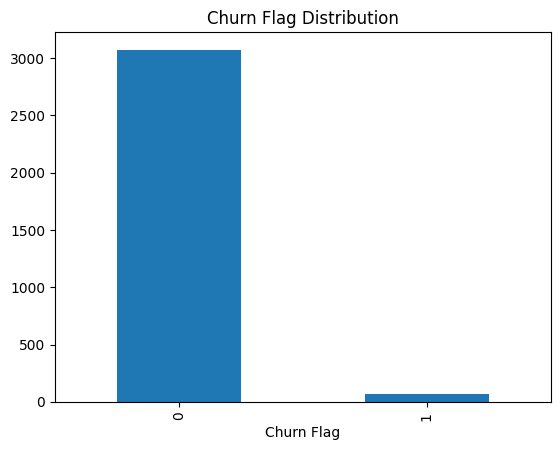

In [9]:
# visualize the distribution of the 'Churn Flag' => check for class imbalance
if 'Churn Flag' in b30_pro.columns:
    churn_counts = b30_pro['Churn Flag'].value_counts()
    print(f"Churn Flag Distribution:\n{churn_counts}")
    churn_counts.plot(kind='bar', title='Churn Flag Distribution')
    plt.show()

This suggests that the dataset is highly imbalanced!

In [10]:
# Separate churned and non-churned records
churned = b30_pro[b30_pro['Churn Flag'] == 1]
non_churned = b30_pro[b30_pro['Churn Flag'] == 0]

# Plot the distribution of a feature for churned vs non-churned customers
def plot_feature_distribution(data, feature, churned_data, non_churned_data):
    # Plot the distributions
    plt.figure(figsize=(12, 6))
    sns.histplot(churned_data[feature], color='red', label='Churned', kde=True, stat='density', bins=30)
    sns.histplot(non_churned_data[feature], color='blue', label='Non-Churned', kde=True, stat='density', bins=30)
    plt.title(f'Distribution of {feature}: Churned vs Non-Churned')
    plt.legend()
    plt.show()

# List of numerical features (seen from the data info)
numerical_features = ['last boot - interval', 'last boot - active', 'return - activate']

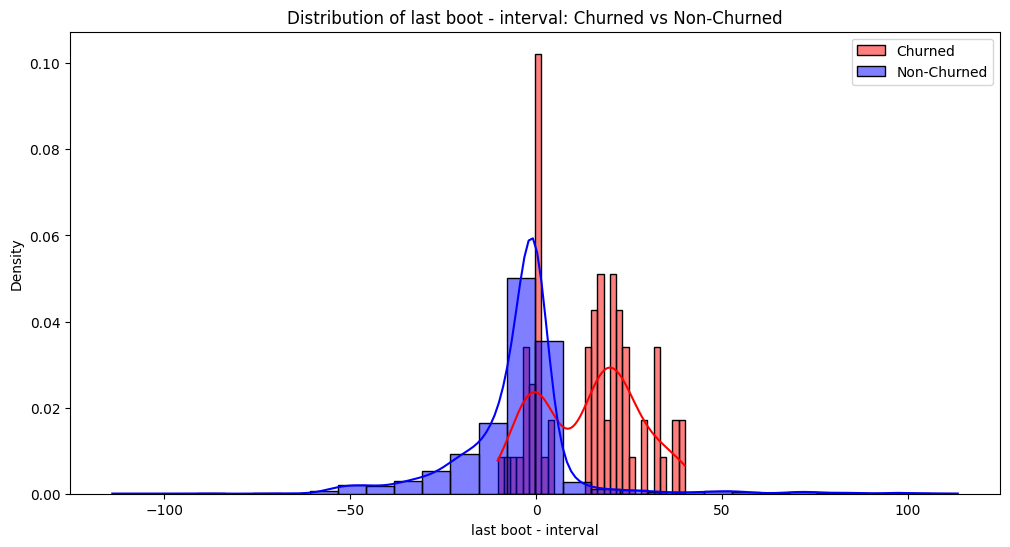

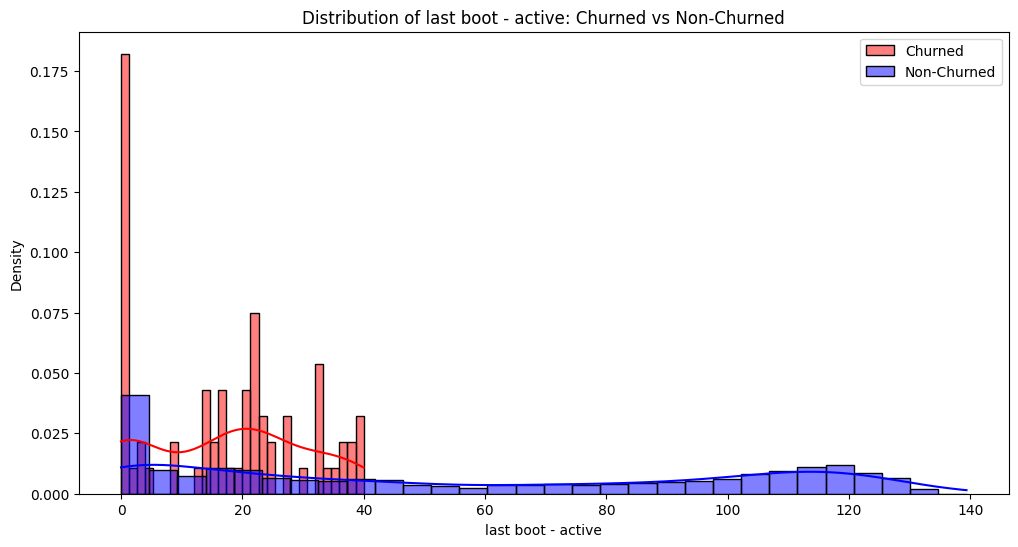

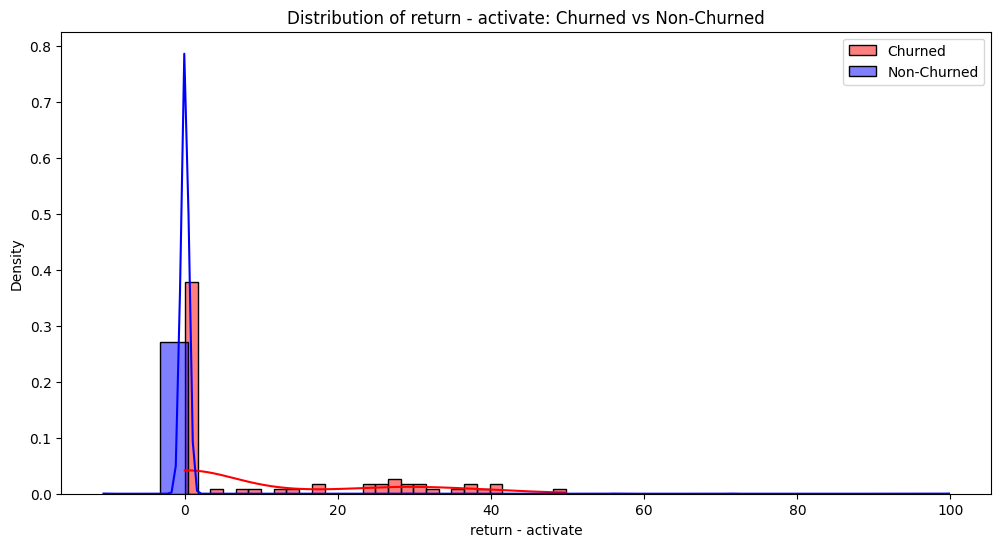

In [11]:
# Loop through each numerical feature and plot the distribution
for feature in numerical_features:
    plot_feature_distribution(b30_pro, feature, churned, non_churned)

In [12]:
# Conduct T-test on the numerical features
for feature in numerical_features:
    t_stat, p_val = stats.ttest_ind(churned[feature], non_churned[feature], equal_var=False)
    print(f"T-test for '{feature}' p-value: {p_val}")

T-test for 'last boot - interval' p-value: 3.5534948409265625e-19
T-test for 'last boot - active' p-value: 7.625494852891254e-43
T-test for 'return - activate' p-value: 3.692385468617318e-07


T-test: a statistical test used to compare the means of two groups (in this case, churned and non-churned customers) to determine if there is a significant difference between them

For each feature, the T-test calculates a p-value, which is the probability that the observed difference in means is due to chance. A small p-value (typically less than 0.05) suggests that the difference between the groups is statistically significant => the feature is likely to be associated with the churned/non-churned classification.

Since all of the p-values are very small (well below the typical significance threshold of 0.05), we can conclude that all three numerical features—last boot - interval, last boot - active, and return - activate—are significantly different between churned and non-churned customers. These features are likely to play a role in predicting whether a customer will churn.

In [13]:
# Calculate the Cohen's d for each numerical features
def cohen_d(x1, x2):
    return (x1.mean() - x2.mean()) / ((x1.std() ** 2 + x2.std() ** 2) / 2) ** 0.5

for feature in numerical_features:
    d_value = cohen_d(churned[feature], non_churned[feature])
    print(f"Cohen’s d for '{feature}': {d_value}")

Cohen’s d for 'last boot - interval': 1.2957851367769138
Cohen’s d for 'last boot - active': -1.1533269328491587
Cohen’s d for 'return - activate': 0.9372115045655316


Cohen's d is a measure of the effect size, which quantifies the magnitude of the difference between two groups, helping to determine whether the difference between the two groups is practiccally significant. 

All three features (last boot - interval, last boot - active, and return - activate) have large effect sizes (Cohen's d > 0.8), indicating that they not only show statistically significant differences between churned & non-churned customers, but also have substantial practical significance in predicting churn.

Churn Rate by Bin for last boot - interval:
last boot - interval_bin
(-113.94, -9.345]    0.001272
(-9.345, -2.096]     0.005096
(-2.096, 0.238]      0.017834
(0.238, 113.382]     0.064885
Name: Churn Flag, dtype: float64


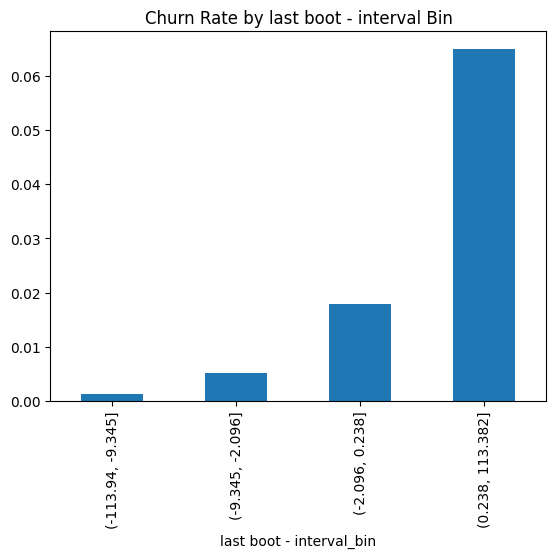

Churn Rate by Bin for last boot - active:
last boot - active_bin
(-0.001, 10.965]      0.029262
(10.965, 43.407]      0.059873
(43.407, 103.791]     0.000000
(103.791, 139.369]    0.000000
Name: Churn Flag, dtype: float64


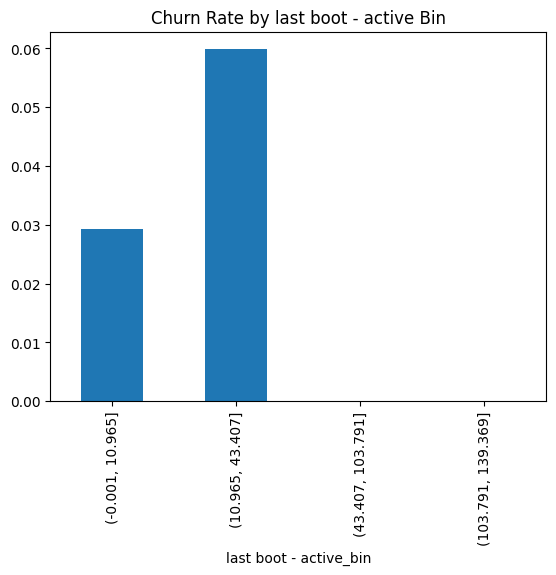

Churn Rate by Bin for return - activate:
return - activate_bin
(-10.616, 0.0]    0.014139
(0.0, 99.807]     0.866667
Name: Churn Flag, dtype: float64


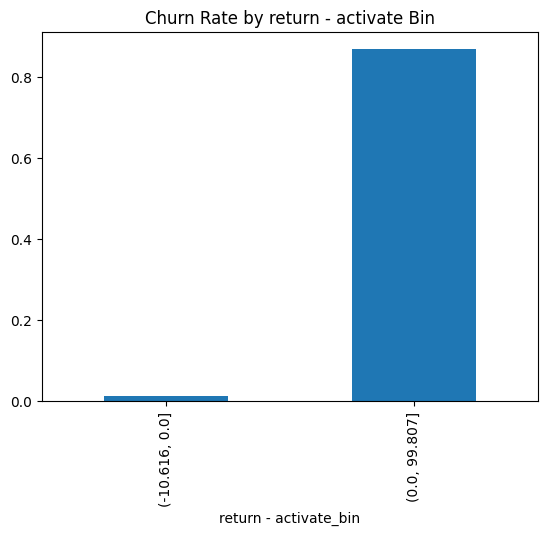

In [14]:
# Bin the numerical features into quartiles and plot the churn rate by bin
for feature in numerical_features:
    # Bin the feature into quartiles
    b30_pro[f'{feature}_bin'] = pd.qcut(b30_pro[feature], q=4, duplicates='drop')

    # Calculate the churn rate by bin
    churn_rate_by_bin = b30_pro.groupby(f'{feature}_bin', observed=True)['Churn Flag'].mean()

    # Print and plot
    print(f"Churn Rate by Bin for {feature}:")
    print(churn_rate_by_bin)
    churn_rate_by_bin.plot(kind='bar', title=f'Churn Rate by {feature} Bin')
    plt.show()

- For 'last boot - interval', a greater time between the last boot and the interval date correlates with a higher churn rate.
- For 'last boot - active', devices with long periods between boot and activity show no churn, suggesting active devices are less likely to churn.
- For 'return - activate', a longer time between return and activation significantly increases the churn rate, indicating a strong relationship between these two events.

Correlation with Churn Flag:
 Churn Flag              1.000000
return - activate       0.404630
last boot - interval    0.171179
last boot - active     -0.125439
Name: Churn Flag, dtype: float64


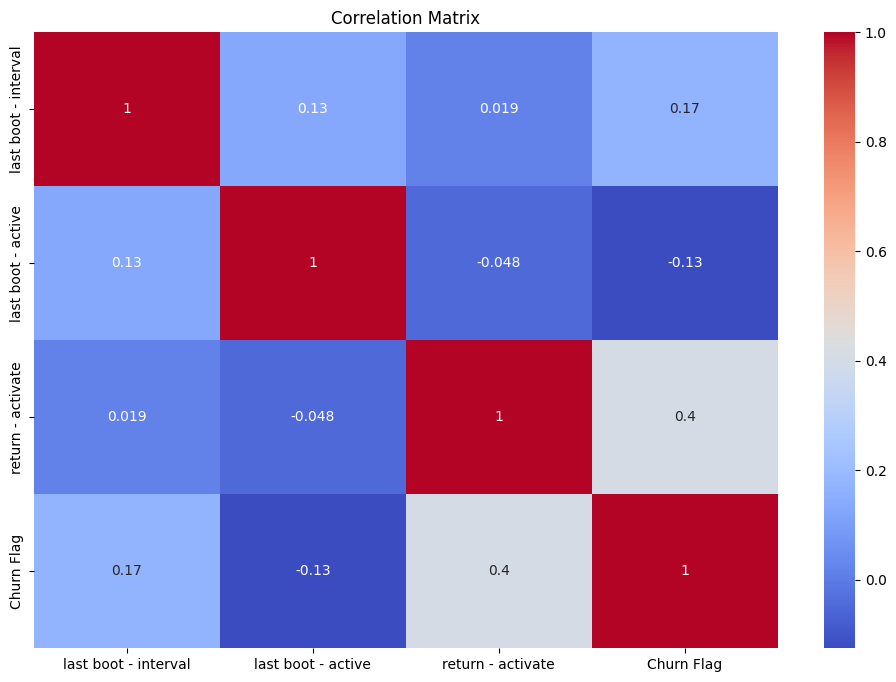

In [15]:
# Analyze correlation between numeric features and 'Churn Flag'
numeric_data = b30_pro.select_dtypes(include=['float64', 'int64'])
corr_with_churn = numeric_data.corr()['Churn Flag'].sort_values(ascending=False)
print("Correlation with Churn Flag:\n", corr_with_churn)

# Visualize the correlation matrix
corr_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The correlation matrix visualizes the correlations between all numeric features in the dataset:
- Churn Flag has the strongest correlation with return - activate, which is expected based on the correlation value of 0.4046.
- The correlations between other numeric features (last boot - interval & last boot - active) are relatively weak.

In [16]:
# Print the clustering results for non-churned records
clustering_result = b30_pro[b30_pro['Churn Flag'] == 0][['last boot - interval', 'last boot - active', 'Churn Prediction']]
print(clustering_result.head())  # Print the first few records to check

# Print the count of each cluster to understand the distribution
cluster_counts = b30_pro[b30_pro['Churn Flag'] == 0]['Churn Prediction'].value_counts()
print(f"\nCluster Distribution:\n{cluster_counts}")

# Select the numerical features for clustering
features_for_clustering = b30_pro[b30_pro['Churn Flag'] == 0][numerical_features]

# Apply KMeans clustering (e.g., 2 clusters for simplicity)
kmeans = KMeans(n_clusters=2, random_state=42)
b30_pro.loc[b30_pro['Churn Flag'] == 0, 'Churn Prediction'] = kmeans.fit_predict(features_for_clustering)

# Plot the clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(data=b30_pro[b30_pro['Churn Flag'] == 0], x='last boot - interval', y='last boot - active', hue='Churn Prediction', palette='Set1')
plt.title("Clustering of Non-Churned Records (Flag = 0)")
plt.show()

KeyError: "['Churn Prediction'] not in index"

- Cluster Distribution (cluster_counts) shows the distribution of the non-churned records across the two clusters:
    - Cluster 1 (Churn Prediction = 1.0) contains 1678 records.
    - Cluster 0 (Churn Prediction = 0.0) contains 1394 records.
- This suggests that KMeans has identified two distinct groups of non-churned records based on the features last boot - interval and last boot - active. The two clusters appear to represent two different behaviors based on the last boot - interval and last boot - active values.